## 内容概要
- 模型评估的目的及一般评估流程
- 分类准确率的用处及其限制
- 混淆矩阵（confusion matrix）是如何表示一个分类器的性能
- 混淆矩阵中的度量是如何计算的
- 通过改变分类阈值来调整分类器性能
- ROC曲线的用处
- 曲线下面积（Area Under the Curve, AUC）与分类准确率的不同

## 1. 回顾
模型评估可以用于在不同的模型类型、调节参数、特征组合中选择适合的模型，所以我们需要一个模型评估的流程来估计训练得到的模型对于非样本数据的泛化能力，并且还需要恰当的模型评估度量手段来衡量模型的性能表现。

对于模型评估流程而言，之前介绍了K折交叉验证的方法，针对模型评估度量方法，回归问题可以采用平均绝对误差（Mean Absolute Error）、均方误差（Mean Squared Error）、均方根误差（Root Mean Squared Error），而分类问题可以采用分类准确率和这篇文章中介绍的度量方法。

## 2. 分类准确率（Classification accuracy）
这里我们使用Pima Indians Diabetes dataset，其中包含健康数据和糖尿病状态数据，一共有768个病人的数据。

In [1]:
# read the data into a Pandas DataFrame
import pandas as pd
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
pima = pd.read_csv(url, header=None, names=col_names)

In [2]:
# print the first 5 rows of data
pima.head()

pregnant  glucose  bp  skin  insulin   bmi  pedigree  age  label
0         6      148  72    35        0  33.6     0.627   50      1
1         1       85  66    29        0  26.6     0.351   31      0
2         8      183  64     0        0  23.3     0.672   32      1
3         1       89  66    23       94  28.1     0.167   21      0
4         0      137  40    35      168  43.1     2.288   33      1

上面表格中的label一列，1表示该病人有糖尿病，0表示该病人没有糖尿病

In [3]:
# define X and y
feature_cols = ['pregnant', 'insulin', 'bmi', 'age']
X = pima[feature_cols]
y = pima.label

In [4]:
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [5]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [6]:
# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

In [7]:
# calculate accuracy
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.692708333333


**分类准确率**分数是指所有分类正确的百分比。

**空准确率（null accuracy）**是指当模型总是预测比例较高的类别，那么其正确的比例是多少

In [8]:
# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

0    130
1     62
dtype: int64

In [9]:
# calculate the percentage of ones
y_test.mean()

0.32291666666666669

In [10]:
# calculate the percentage of zeros
1 - y_test.mean()

0.67708333333333326

In [11]:
# calculate null accuracy(for binary classification problems coded as 0/1)
max(y_test.mean(), 1-y_test.mean())

0.67708333333333326

我们看到空准确率是68%，而分类准确率是69%，这说明该分类准确率并不是很好的模型度量方法，**分类准确率的一个缺点是其不能表现任何有关测试数据的潜在分布。**

In [12]:
# calculate null accuracy (for multi-class classification problems)
y_test.value_counts().head(1) / len(y_test)

0    0.677083
dtype: float64

比较真实和预测的类别响应值：

In [13]:
# print the first 25 true and predicted responses
print "True:", y_test.values[0:25]
print "Pred:", y_pred_class[0:25]

True: [1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0]
Pred: [0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


从上面真实值和预测值的比较中可以看出，当正确的类别是0时，预测的类别基本都是0；当正确的类别是1时，预测的类别大都不是1。换句话说，该训练的模型大都在比例较高的那项类别的预测中预测正确，而在另外一中类别的预测中预测失败，而我们没法从分类准确率这项指标中发现这个问题。

分类准确率这一衡量分类器的标准比较容易理解，但是**它不能告诉你响应值的潜在分布，并且它也不能告诉你分类器犯错的类型**。接下来介绍的混淆矩阵可以识别这个问题。

## 3. 混淆矩阵

In [14]:
# IMPORTANT: first argument is true values, second argument is predicted values
print metrics.confusion_matrix(y_test, y_pred_class)

[[118  12]
 [ 47  15]]


![](Image/confusion_matrix.png)

- 真阳性（True Positive，TP）：指被分类器正确分类的正例数据
- 真阴性（True Negative，TN）：指被分类器正确分类的负例数据
- 假阳性（False Positive，FP）：被错误地标记为正例数据的负例数据
- 假阴性（False Negative，FN）：被错误地标记为负例数据的正例数据

In [15]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print "TP:", TP
print "TN:", TN
print "FP:", FP
print "FN:", FN

TP: 15
TN: 118
FP: 12
FN: 47


## 4. 基于混淆矩阵的评估度量

**准确率、识别率（Classification Accuracy）**：分类器正确分类的比例

In [16]:
print (TP+TN) / float(TP+TN+FN+FP)
print metrics.accuracy_score(y_test, y_pred_class)

0.692708333333
0.692708333333


**错误率、误分类率（Classification Error）**：分类器误分类的比例

In [17]:
print (FP+FN) / float(TP+TN+FN+FP)
print 1-metrics.accuracy_score(y_test, y_pred_class)

0.307291666667
0.307291666667


考虑**类不平衡问题**，其中感兴趣的主类是稀少的。即数据集的分布反映负类显著地占多数，而正类占少数。故面对这种问题，需要其他的度量，评估分类器正确地识别正例数据的情况和正确地识别负例数据的情况。

**灵敏性（Sensitivity），也称为真正例识别率、召回率（Recall）**：正确识别的正例数据在实际正例数据中的百分比

In [18]:
print TP / float(TP+FN)
recall = metrics.recall_score(y_test, y_pred_class)
print metrics.recall_score(y_test, y_pred_class)

0.241935483871
0.241935483871


**特效性（Specificity），也称为真负例率**：正确识别的负例数据在实际负例数据中的百分比

In [19]:
print TN / float(TN+FP)

0.907692307692


**假阳率（False Positive Rate）**：实际值是负例数据，预测错误的百分比

In [20]:
print FP / float(TN+FP)
specificity = TN / float(TN+FP)
print 1 - specificity

0.0923076923077
0.0923076923077


**精度（Precision）**：看做精确性的度量，即标记为正类的数据实际为正例的百分比

In [21]:
print TP / float(TP+FP)
precision = metrics.precision_score(y_test, y_pred_class)
print precision

0.555555555556
0.555555555556


**F度量（又称为F1分数或F分数）**，是使用精度和召回率的方法组合到一个度量上
$$F = \frac{2*precision*recall}{precision+recall}$$
$$F_{\beta} = \frac{(1+{\beta}^2)*precision*recall}{{\beta}^2*precision+recall}$$

$F$度量是精度和召回率的调和均值，它赋予精度和召回率相等的权重。

$F_{\beta}$度量是精度和召回率的加权度量，它赋予召回率权重是赋予精度的$\beta$倍。

In [22]:
print (2*precision*recall) / (precision+recall)
print metrics.f1_score(y_test, y_pred_class)

0.337078651685
0.337078651685


**总结**

混淆矩阵赋予一个分类器性能表现更全面的认识，同时它通过计算各种分类度量，指导你进行模型选择。

使用什么度量取决于具体的业务要求：
- 垃圾邮件过滤器：优先优化**精度**或者**特效性**，因为该应用对假阳性（非垃圾邮件被放进垃圾邮件箱）的要求高于对假阴性（垃圾邮件被放进正常的收件箱）的要求
- 欺诈交易检测器：优先优化**灵敏度**，因为该应用对假阴性（欺诈行为未被检测）的要求高于假阳性（正常交易被认为是欺诈）的要求

## 5. 调整分类的阈值

In [23]:
# print the first 10 predicted responses
logreg.predict(X_test)[0:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1], dtype=int64)

In [24]:
y_test.values[0:10]

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 0], dtype=int64)

In [25]:
# print the first 10 predicted probabilities of class membership
logreg.predict_proba(X_test)[0:10, :]

array([[ 0.63247571,  0.36752429],
       [ 0.71643656,  0.28356344],
       [ 0.71104114,  0.28895886],
       [ 0.5858938 ,  0.4141062 ],
       [ 0.84103973,  0.15896027],
       [ 0.82934844,  0.17065156],
       [ 0.50110974,  0.49889026],
       [ 0.48658459,  0.51341541],
       [ 0.72321388,  0.27678612],
       [ 0.32810562,  0.67189438]])

上面的输出中，第一列显示的是预测值为0的百分比，第二列显示的是预测值为1的百分比。

In [26]:
# print the first 10 predicted probabilities for class 1
logreg.predict_proba(X_test)[0:10, 1]

array([ 0.36752429,  0.28356344,  0.28895886,  0.4141062 ,  0.15896027,
        0.17065156,  0.49889026,  0.51341541,  0.27678612,  0.67189438])

我们看到，预测为1的和实际的类别号差别很大，所以这里有50%作为分类的阈值显然不太合理。于是我们将所有预测类别为1的百分比数据用直方图的方式形象地表示出来，然后尝试重新设置阈值。

In [27]:
# store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [28]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

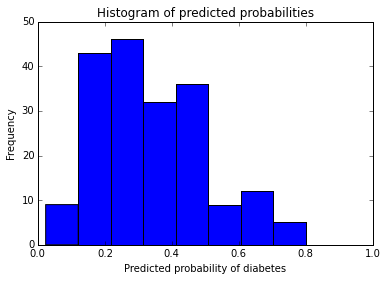

In [29]:
# histogram of predicted probabilities
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

我们发现在20%-30%之间的数高达45%，故以50%作为分类阈值时，只有很少的一部分数据会被认为是类别为1的情况。我们可以将阈值调小，以改变分类器的**灵敏度和特效性**。

In [30]:
# predict diabetes if the predicted probability is greater than 0.3
from sklearn.preprocessing import binarize
y_pred_class = binarize(y_pred_prob, 0.3)[0]

In [31]:
# print the first 10 predicted probabilities
y_pred_prob[0:10]

array([ 0.36752429,  0.28356344,  0.28895886,  0.4141062 ,  0.15896027,
        0.17065156,  0.49889026,  0.51341541,  0.27678612,  0.67189438])

In [32]:
# print the first 10 predicted classes with the lower threshold
y_pred_class[0:10]

array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.])

In [33]:
y_test.values[0:10]

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 0], dtype=int64)

从上面两组数据对比来看，效果确实改善不少

In [34]:
# previous confusion matrix (default threshold of 0.5)
print confusion

[[118  12]
 [ 47  15]]


In [35]:
# new confusion matrix (threshold of 0.3)
print metrics.confusion_matrix(y_test, y_pred_class)

[[80 50]
 [16 46]]


In [36]:
# sensitivity has increased (used to be 0.24)
print 46 / float(46 + 16)
print metrics.recall_score(y_test, y_pred_class)

0.741935483871
0.741935483871


In [37]:
# specificity has decreased (used to be 0.91)
print 80 / float(80 + 50)

0.615384615385


**总结：**
- 0.5作为阈值时默认的情况
- 调节阈值可以改变灵敏性和特效性
- 灵敏性和特效性是一对相反作用的指标
- 该阈值的调节是作为改善分类性能的最后一步，应更多去关注分类器的选择或构建更好的分类器

## 6. ROC曲线和AUC
ROC曲线指受试者工作特征曲线/接收器操作特性(receiver operating characteristic，ROC)曲线, 是反映灵敏性和特效性连续变量的综合指标,是用构图法揭示敏感性和特异性的相互关系，它通过将连续变量设定出多个不同的临界值，从而计算出一系列敏感性和特异性。

ROC曲线是根据一系列不同的二分类方式（分界值或决定阈），以真正例率（也就是灵敏度）（True Positive Rate,TPR）为纵坐标，假正例率（1-特效性）（False Positive Rate,FPR）为横坐标绘制的曲线。

**ROC观察模型正确地识别正例的比例与模型错误地把负例数据识别成正例的比例之间的权衡。TPR的增加以FPR的增加为代价。ROC曲线下的面积是模型准确率的度量。**

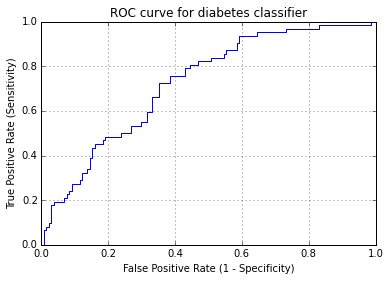

In [38]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

ROC曲线上的每一个点对应于一个threshold，对于一个分类器，每个threshold下会有一个TPR和FPR。
比如Threshold最大时，TP=FP=0，对应于原点；Threshold最小时，TN=FN=0，对应于右上角的点(1,1)


正如上面所述，TPR的增加以FPR的增加为代价，所以ROC曲线可以帮助我们选择一个可以平衡灵敏性和特效性的阈值。通过ROC曲线我们没法看到响应阈值的对应关系，所以我们用下面的函数来查看。

In [39]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print 'Sensitivity:', tpr[thresholds > threshold][-1]
    print 'Specificity:', 1 - fpr[thresholds > threshold][-1]

In [40]:
evaluate_threshold(0.5)

Sensitivity: 0.241935483871
Specificity: 0.907692307692


In [41]:
evaluate_threshold(0.3)

Sensitivity: 0.741935483871
Specificity: 0.615384615385


AUC（Area Under Curve）被定义为ROC曲线下的面积，也可以认为是ROC曲线下面积占单位面积的比例，显然这个面积的数值不会大于1。又由于ROC曲线一般都处于y=x这条直线的上方，所以AUC的取值范围在0.5和1之间。

**对应AUC更大的分类器效果更好。**所以AUC是衡量分类器性能的一个很好的度量，并且它不像分类准确率那样，在类别比例差别很大的情况下，依然是很好的度量手段。在欺诈交易检测中，由于欺诈案例是很小的一部分，这时分类准确率就不再是一个良好的度量，而可以使用AUC来度量。

In [42]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print metrics.roc_auc_score(y_test, y_pred_prob)

0.724565756824


In [43]:
# calculate cross-validated AUC
from sklearn.cross_validation import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.73782336182336183

## 参考资料
- scikit-learn documentation: [Model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)
- [ROC曲线-阈值评价标准](http://blog.csdn.net/abcjennifer/article/details/7359370)